# 2D - Advection-Dispersion, Finite-Width, Finite-Duration Source

![](2Dgeom2.png)

The sketch depicts a finite-length horizontal line source in an aquifer of infinite extent located at $(x,y)=(0,0)$. The lenght of the source zone (line) is Y. The source history is depicted beneath the sketch. The system starts with initial concentration of zero everywhere, at time $t=0$, the concentration in the source line increases to $C_0$ suddenly, and is maintained at that value for a specified duration ($\tau$), when the source then decreases back to zero.

An analytical model based on Domenico and Robbins (1985) was obtained by convolution (temporal superposition) of two continuous sources shifted in time relative to one another, with the later source having opposite sense (sign) (This  particular solution is described in detail in Yuan, 1995):

$$ C(x,y,t) = \frac{C_0}{4} \cdot \textit{erfc}[\frac{(x - v t) }{ (2 \sqrt{D_x  t))}}] \cdot [\textit{erf}(\frac{(y + \frac{Y}{2}) }{ (2 \sqrt{\frac{D_y}{v} x))}}) - \textit{erf} (\frac{(y - \frac{Y}{2}) }{ (2 \sqrt{\frac{D_y}{v} x))}})]  ~ - \frac{C_0}{4} \cdot \textit{erfc}[\frac{(x - v (t-\tau)) }{ (2 \sqrt{D_x  (t-\tau)))}}] \cdot [\textit{erf}(\frac{(y + \frac{Y}{2}) }{ (2 \sqrt{\frac{D_y}{v} x))}}) - \textit{erf} (\frac{(y - \frac{Y}{2}) }{ (2 \sqrt{\frac{D_y}{v} x))}})]$$

A prototype function is constructed from `c2ad` as follows:

In [1]:
# prototype 2D domenico robbins ADE function
def c2adfd(conc0, distx, disty, dispx, dispy, velocity, time, lenY, tau):
    import math
    from scipy.special import erf, erfc # scipy needs to already be loaded into the kernel
# internal definition of ordinary c2ad function ########################
    def c2ad(conc0, distx, disty, dispx, dispy, velocity, time, lenY):

        vadj = velocity / 1.0 # structure is in anticipation of adding adsorbtion and decay
        dispXadj = dispx / 1.0
        dispYadj = dispy / 1.0
        lambadj = 0 / 1.0

        uuu = math.sqrt(1.0 + 4.0*lambadj*dispXadj/vadj)
        ypp = (disty + 0.5*lenY) / (2*math.sqrt(dispYadj*distx))
        ymm = (disty - 0.5*lenY) / (2*math.sqrt(dispYadj*distx))

        arg1 = (distx - vadj*time*uuu) / (2*math.sqrt(dispXadj*vadj*time))
        arg2 = (distx / (2*dispXadj)) * (1 - uuu)

        term0 = conc0 / 4
        term1 = math.exp(arg2)
        term2 = erfc(arg1)
        term3 = (erf(ypp) - erf(ymm))

        c2ad = term0 * term1 * term2 * term3
        return c2ad
#########################################################################
    part1 = c2ad(conc0, distx, disty, dispx, dispy, velocity, time, lenY)
    part2 = c2ad(conc0, distx, disty, dispx, dispy, velocity, time-tau , lenY) #time-shift here
    c2adfd = part1-part2
    return c2adfd


Supply model conditions, evaluate specific point in space and time.

In [2]:
# inputs
c_initial = 100.0 # g/m^3
xx = 75          # meters
yy = 0            # meters
Dx = 0.50          # m^2/day
Dy = 0.05          # m^2/day
V  = 1.0           # m/day
time = 365.0      # days
tau  = 90.0      # days
Y  = 10.0          # meters
alphax = Dx/V
alphay = Dy/V
output=c2adfd(c_initial, xx, yy, alphax, alphay, V, time, Y, tau)
print("x= ",round(xx,2)," y= ",round(yy,2)," t= ",round(time,1)," C(x,y,t) = ",round(output,3))

x=  75  y=  0  t=  365.0  C(x,y,t) =  0.0


Construct 2D contour plots (equivalent to a profile plot)

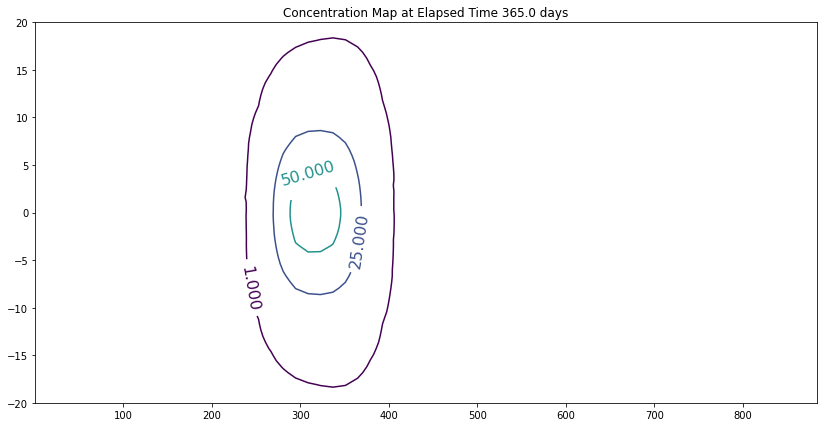

In [3]:
# make a plot
x_max = 900
y_max = 20
# build a grid
nrows = 50   
deltax = (x_max)/nrows
x = []
x.append(1)
for i in range(nrows):
    if x[i] == 0.0:
        x[i] = 0.00001
    x.append(x[i]+deltax)

ncols = 50   
deltay = (y_max*2)/(ncols-1)
y = []
y.append(-y_max)
for i in range(1,ncols):
    if y[i-1] == 0.0:
        y[i-1] = 0.00001
    y.append(y[i-1]+deltay)
    
#y

#y = [i*deltay for i in range(how_many_points)] # constructor notation
#y[0]=0.001
ccc = [[0 for i in range(nrows)] for j in range(ncols)]

for jcol in range(ncols):
    for irow in range(nrows):
        ccc[irow][jcol] = c2adfd(c_initial, x[irow], y[jcol], alphax, alphay, V, time, Y, tau)
        
#y

my_xyz = [] # empty list
count=0
for irow in range(nrows):
    for jcol in range(ncols):
        my_xyz.append([ x[irow],y[jcol],ccc[irow][jcol] ])
       # print(count)
        count=count+1
        
#print(len(my_xyz))

import pandas
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
#print(min(coord_x), max(coord_x)) # activate to examine the dataframe
#print(min(coord_y), max(coord_y))
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 64)
lat = numpy.linspace(min(coord_y), max(coord_y), 64)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(14, 7)
CS = ax.contour(X, Y, Z, levels = [1,25,50,75,99])
ax.clabel(CS, inline=1, fontsize=16)
ax.set_title('Concentration Map at Elapsed Time '+ str(round(time,1))+' days');

## References
5. [Analytical solutions for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow
Open-File Report 89-56](https://pubs.usgs.gov/publication/ofr8956)
6. [Analytical solutions for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow
Techniques of Water-Resources Investigations 03-B7 (supercedes above reference)](https://pubs.usgs.gov/publication/twri03B7)